<a href="https://www.linkedin.com/in/hern%C3%A1n-contigiani-41260679/"><img src="https://raw.githubusercontent.com/hernancontigiani/tf_certification/main/images/hc_banner.png" width="1000" align="center"></a>


# Tensorflow Developer Certification

Timeseries practice

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

In [ ]:
!wget https://raw.githubusercontent.com/hernancontigiani/tf_certification/main/utils_tf.py
from utils_tf import *

### Create dataset

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-12-21 11:52:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2021-12-21 11:52:27 (6.14 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv")
df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.65499,124.30466,124.75166,122.56349
1,BTC,2013-10-02,125.45500,123.65499,125.75850,123.63383
2,BTC,2013-10-03,108.58483,125.45500,125.66566,83.32833
3,BTC,2013-10-04,118.67466,108.58483,118.67500,107.05816
4,BTC,2013-10-05,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2787 entries, 0 to 2786
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Date                 2787 non-null   object 
 2   Closing Price (USD)  2787 non-null   float64
 3   24h Open (USD)       2787 non-null   float64
 4   24h High (USD)       2787 non-null   float64
 5   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(2)
memory usage: 130.8+ KB


In [ ]:
timesteps = pd.to_datetime(df['Date'], format="%Y-%m-%d").to_numpy()
timesteps[:10]

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
       '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
       '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
       '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
price = df['Closing Price (USD)'].to_numpy()
price[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

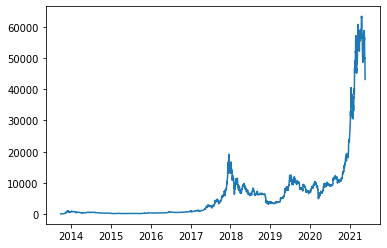

In [ ]:
plt.plot(timesteps, price)

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(price)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], price[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], price[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

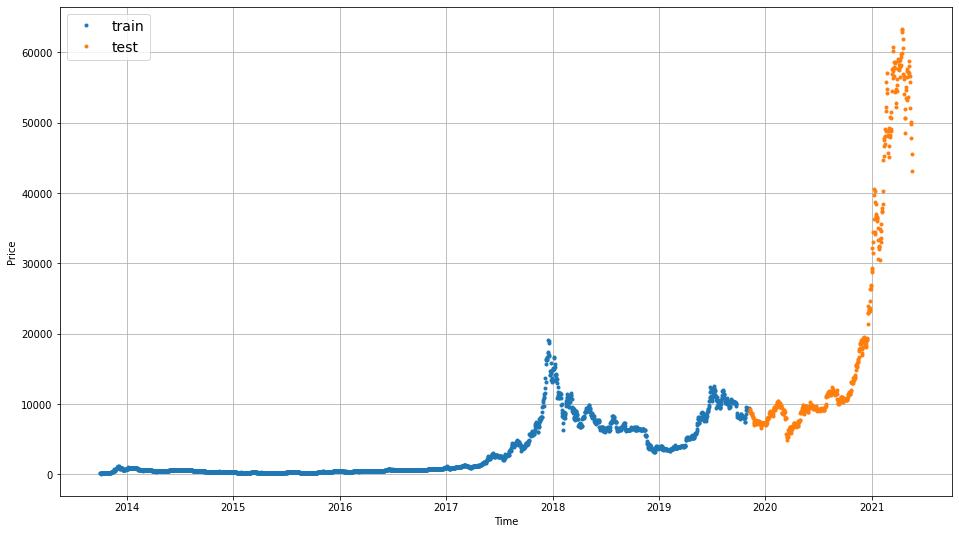

In [ ]:
fig = plt.figure(figsize=(16,9))
plot_time_series(X_train, y_train, label="train")
plot_time_series(X_test, y_test, label="test")
plt.show()

### Evaluate model

In [ ]:
# Usa Mean absule error (MAE) scaled (MASE)
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season

In [ ]:
def forescast_evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, reduce to single number)
    if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

### Naïve forecast (baseline)

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (the previous timestep).

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value

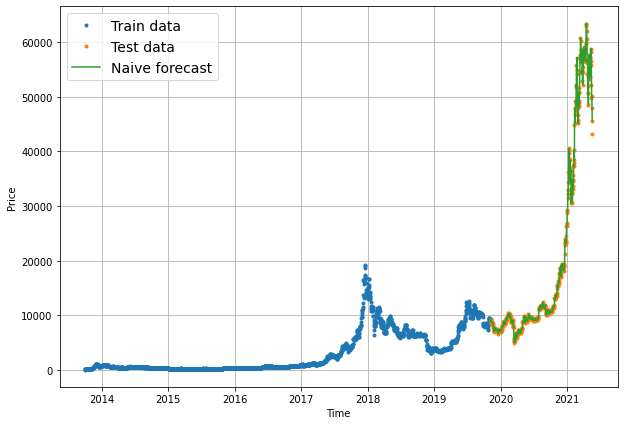

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

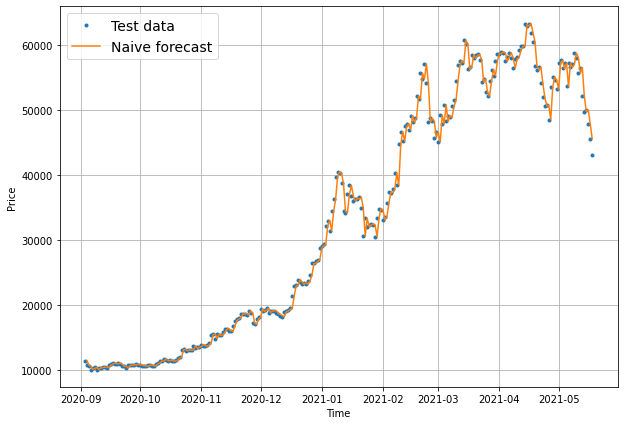

In [ ]:
# offset the values by 300 timesteps 
plt.figure(figsize=(10, 7))
offset = 300 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [ ]:
naive_results = forescast_evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

### Create window dataset

In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [ ]:
full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# Make the train/test window split
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

### Dense Model (w=7 h=1

In [ ]:
train_windows.shape

(2224, 7)

In [ ]:
train_labels.shape

(2224, 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu", input_shape=(WINDOW_SIZE,)),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1024      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=10,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/10
18/18 [==============================] - 2s 59ms/step - loss: 780.3469 - mae: 780.3469 - val_loss: 2279.5828 - val_mae: 2279.5828
Epoch 2/10
18/18 [==============================] - 1s 38ms/step - loss: 247.6765 - mae: 247.6765 - val_loss: 1005.9864 - val_mae: 1005.9864
Epoch 3/10
18/18 [==============================] - 1s 37ms/step - loss: 188.4107 - mae: 188.4107 - val_loss: 923.2859 - val_mae: 923.2859
Epoch 4/10
18/18 [==============================] - 1s 36ms/step - loss: 169.4334 - mae: 169.4334 - val_loss: 900.5932 - val_mae: 900.5932
Epoch 5/10
18/18 [==============================] - 1s 38ms/step - loss: 165.0899 - mae: 165.0899 - val_loss: 895.2405 - val_mae: 895.2405
Epoch 6/10
18/18 [==============================] - 1s 37ms/step - loss: 158.5206 - mae: 158.5206 - val_loss: 855.1868 - val_mae: 855.1868
Epoch 7/10
18/18 [==============================] - 1s 37ms/step - loss: 151.3568 - mae: 151.3568 - val_loss: 840.9290 - val_mae: 840.9290
Epoch 8/10
18/18 [=====

In [ ]:
model_1_preds = model_1.predict(test_windows)
model_1_preds.shape

(556, 1)

In [ ]:
model_1_results = forescast_evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=tf.squeeze(model_1_preds))
model_1_results

{'mae': 763.506,
 'mape': 3.3924627,
 'mase': 1.3412685,
 'mse': 1933137.0,
 'rmse': 1390.3729}

In [ ]:
test_labels.shape

(556, 1)

In [ ]:
X_test.shape

(558,)

In [ ]:
# The delay of HORIZON (1 start and 1 at the end)
# take the last "test_windows" size values
X_test[-len(test_windows):].shape

(556,)

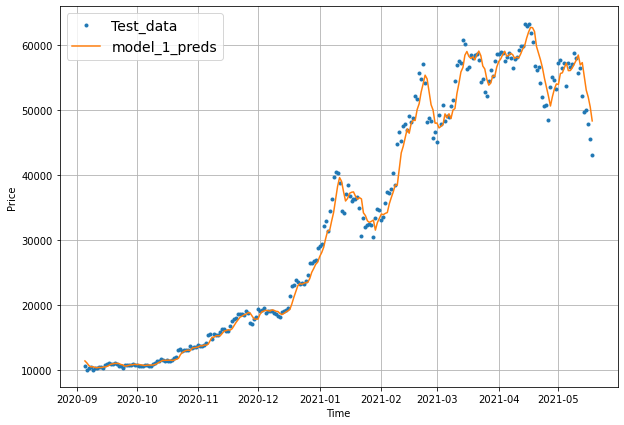

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds[:, 0], start=offset, format="-", label="model_1_preds")

### Model 3: Dense (window = 30, horizon = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2200, 2200, 551, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu", input_shape=(WINDOW_SIZE,)),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.summary()

Model: "model_3_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               3968      
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 4,871
Trainable params: 4,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=20,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/20
18/18 [==============================] - 1s 67ms/step - loss: 262.5755 - val_loss: 1382.7981
Epoch 2/20
18/18 [==============================] - 0s 6ms/step - loss: 258.5410 - val_loss: 1421.0117
Epoch 3/20
18/18 [==============================] - 0s 6ms/step - loss: 253.1149 - val_loss: 1502.4270
Epoch 4/20
18/18 [==============================] - 1s 65ms/step - loss: 254.0686 - val_loss: 1377.9652
Epoch 5/20
18/18 [==============================] - 0s 6ms/step - loss: 250.8681 - val_loss: 1485.3599
Epoch 6/20
18/18 [==============================] - 0s 7ms/step - loss: 248.5655 - val_loss: 1423.0688
Epoch 7/20
18/18 [==============================] - 0s 7ms/step - loss: 247.8071 - val_loss: 1405.4435
Epoch 8/20
18/18 [==============================] - 0s 6ms/step - loss: 246.4445 - val_loss: 1437.0688
Epoch 9/20
18/18 [==============================] - 0s 6ms/step - loss: 248.2839 - val_loss: 1402.6619
Epoch 10/20
18/18 [==============================] - 1s 58ms/step - los

In [ ]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1384.9260


1384.926025390625

In [ ]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1331.4238


1331.423828125

In [ ]:
model_3_preds = model_3.predict(test_windows)
model_3_results = forescast_evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=tf.squeeze(model_3_preds))
model_3_results

{'mae': 1331.4238,
 'mape': 6.0194874,
 'mase': 2.369194,
 'mse': 6079492.5,
 'rmse': 1520.0919}

In [ ]:
model_3_preds.shape

(551, 7)

In [ ]:
# Mean HORIZON prediction for each timestep
tf.reduce_mean(model_3_preds, axis=1).shape

TensorShape([551])

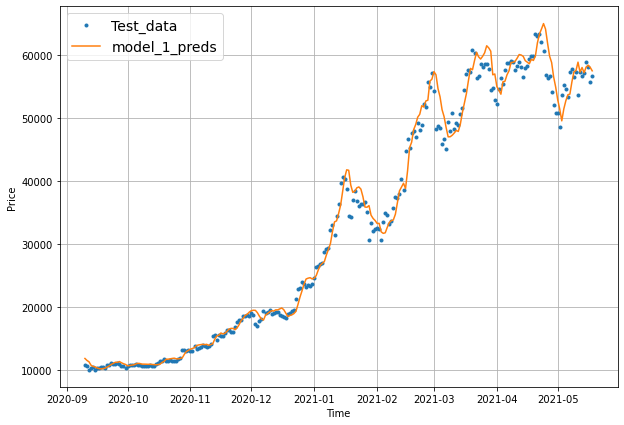

In [ ]:
offset = 300
model_3_preds_mean = tf.reduce_mean(model_3_preds, axis=1)

plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds_mean, start=offset, format="-", label="model_1_preds")

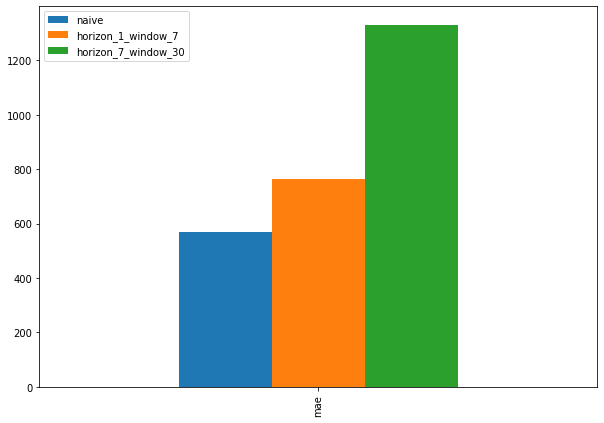

In [ ]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [ ]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [ ]:
# CONV1D expect 2D ARRAY (step, samples), we need to expand our input

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Input(shape=(WINDOW_SIZE,)),
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=20,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/20
18/18 [==============================] - 2s 99ms/step - loss: 1207.3885 - val_loss: 2320.5461
Epoch 2/20
18/18 [==============================] - 1s 49ms/step - loss: 316.2140 - val_loss: 1467.3309
Epoch 3/20
18/18 [==============================] - 1s 51ms/step - loss: 192.6844 - val_loss: 1164.7460
Epoch 4/20
18/18 [==============================] - 1s 52ms/step - loss: 177.3536 - val_loss: 981.6823
Epoch 5/20
18/18 [==============================] - 1s 52ms/step - loss: 172.3469 - val_loss: 960.8795
Epoch 6/20
18/18 [==============================] - 1s 51ms/step - loss: 171.9752 - val_loss: 950.1938
Epoch 7/20
18/18 [==============================] - 1s 50ms/step - loss: 167.1943 - val_loss: 943.3042
Epoch 8/20
18/18 [==============================] - 1s 49ms/step - loss: 163.5994 - val_loss: 905.5258
Epoch 9/20
18/18 [==============================] - 0s 4ms/step - loss: 162.5453 - val_loss: 929.7834
Epoch 10/20
18/18 [==============================] - 1s 48ms/step - lo

In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 712.1983


712.1983032226562

In [ ]:
model_4_preds = model_4.predict(test_windows)
print(model_4_preds.shape)
model_4_results = forescast_evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=tf.squeeze(model_4_preds))
model_4_results

(556, 1, 1)


{'mae': 712.1983,
 'mape': 3.191239,
 'mase': 1.2511351,
 'mse': 1729300.2,
 'rmse': 1315.0286}

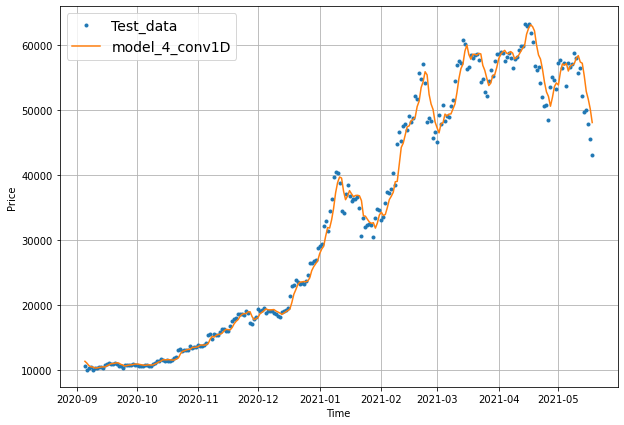

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.squeeze(model_4_preds), start=offset, format="-", label=model_4.name)

### Model 5: RNN (LSTM)

In [ ]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [ ]:
# The tf.keras.layers.LSTM() layer takes a tensor with [batch, timesteps, feature] dimensions.
# same as CONV1D, we need as input a 2D ARRAY, we need to expand dims

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_7 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               69632     
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=20,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/20
15/18 [========================>.....] - ETA: 0s - loss: 2405.3992INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 8s 322ms/step - loss: 2323.6123 - val_loss: 9224.3506
Epoch 2/20
13/18 [====================>.........] - ETA: 0s - loss: 859.7588 INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 152ms/step - loss: 695.4956 - val_loss: 1485.8942
Epoch 3/20
10/18 [===============>..............] - ETA: 0s - loss: 273.3071INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 146ms/step - loss: 237.3010 - val_loss: 1298.9435
Epoch 4/20
10/18 [===============>..............] - ETA: 0s - loss: 200.8831INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 162ms/step - loss: 181.9182 - val_loss: 966.6407
Epoch 5/20
18/18 [==============================] - 0s 8ms/step - loss: 173.4021 - val_loss: 970.9384
Epoch 6/20
 9/18 [==============>...............] - ETA: 0s - loss: 168.0929INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 2s 143ms/step - loss: 172.3319 - val_loss: 891.5209
Epoch 7/20
18/18 [==============================] - 0s 9ms/step - loss: 168.9708 - val_loss: 968.6377
Epoch 8/20
18/18 [==============================] - 0s 12ms/step - loss: 169.5317 - val_loss: 963.4456
Epoch 9/20
18/18 [==============================] - 0s 11ms/step - loss: 167.5760 - val_loss: 956.5829
Epoch 10/20
18/18 [==============================] - 0s 12ms/step - loss: 166.3443 - val_loss: 936.8956
Epoch 11/20
18/18 [==============================] - 0s 9ms/step - loss: 165.4762 - val_loss: 909.1110
Epoch 12/20
18/18 [==============================] - ETA: 0s - loss: 169.9951INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 6s 335ms/step - loss: 169.9951 - val_loss: 891.2327
Epoch 13/20
18/18 [==============================] - 0s 16ms/step - loss: 160.3806 - val_loss: 898.5595
Epoch 14/20
18/18 [==============================] - 0s 13ms/step - loss: 157.6484 - val_loss: 927.9266
Epoch 15/20
18/18 [==============================] - 0s 12ms/step - loss: 167.6508 - val_loss: 982.9256
Epoch 16/20
18/18 [==============================] - 0s 18ms/step - loss: 160.4521 - val_loss: 916.0458
Epoch 17/20
18/18 [==============================] - 0s 14ms/step - loss: 153.8805 - val_loss: 928.6927
Epoch 18/20
18/18 [==============================] - ETA: 0s - loss: 152.1556INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 6s 350ms/step - loss: 152.1556 - val_loss: 865.6219
Epoch 19/20
18/18 [==============================] - 0s 7ms/step - loss: 148.8319 - val_loss: 876.9328
Epoch 20/20
11/18 [=================>............] - ETA: 0s - loss: 153.5789INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


18/18 [==============================] - 3s 167ms/step - loss: 149.6801 - val_loss: 831.2376


In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 831.2377


831.2376708984375

In [ ]:
model_5_preds = model_5.predict(test_windows)
print(model_5_preds.shape)
model_5_results = forescast_evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=tf.squeeze(model_5_preds))
model_5_results

(556, 1)


{'mae': 831.23755,
 'mape': 3.6765025,
 'mase': 1.4602542,
 'mse': 2272233.0,
 'rmse': 1507.3928}

### Model 6: RNN (LSTM) + Normalization

In [ ]:
price.shape

(2787,)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

# split train and test
split_size = int(0.8 * len(price)) # 80% train, 20% test
price_train, price_test = price[:split_size], price[split_size:]

price_train_norm = scaler.fit_transform(price_train.reshape(-1, 1)).reshape(-1)
price_test_norm = scaler.transform(price_test.reshape(-1, 1)).reshape(-1)

print(price_train_norm.shape)
print(price_test_norm.shape)
price_norm = np.concatenate([price_train_norm, price_test_norm])
print(price_norm.shape)


full_windows, full_labels = make_windows(price_norm, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2229,)
(558,)
(2787,)


(2224, 2224, 556, 556)

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_6 = tf.keras.Model(inputs=inputs, outputs=output, name="model_6_lstm")

# Compile model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.summary()

Model: "model_6_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_8 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               69632     
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_6.fit(train_windows,
            train_labels,
            epochs=20,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/20
13/18 [====================>.........] - ETA: 0s - loss: 2475.4385INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


18/18 [==============================] - 9s 307ms/step - loss: 2323.6123 - val_loss: 9224.3506
Epoch 2/20
13/18 [====================>.........] - ETA: 0s - loss: 859.7588 INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


18/18 [==============================] - 4s 254ms/step - loss: 695.4956 - val_loss: 1485.8942
Epoch 3/20
14/18 [======================>.......] - ETA: 0s - loss: 250.9574INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


18/18 [==============================] - 4s 251ms/step - loss: 237.3010 - val_loss: 1298.9435
Epoch 4/20
14/18 [======================>.......] - ETA: 0s - loss: 186.1970INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


18/18 [==============================] - 4s 258ms/step - loss: 181.9182 - val_loss: 966.6407
Epoch 5/20
18/18 [==============================] - 0s 11ms/step - loss: 173.4021 - val_loss: 970.9384
Epoch 6/20
16/18 [=========================>....] - ETA: 0s - loss: 171.8069INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


18/18 [==============================] - 4s 255ms/step - loss: 172.3319 - val_loss: 891.5209
Epoch 7/20
18/18 [==============================] - 0s 11ms/step - loss: 168.9708 - val_loss: 968.6377
Epoch 8/20
18/18 [==============================] - 0s 11ms/step - loss: 169.5317 - val_loss: 963.4456
Epoch 9/20
18/18 [==============================] - 0s 13ms/step - loss: 167.5760 - val_loss: 956.5829
Epoch 10/20
18/18 [==============================] - 0s 10ms/step - loss: 166.3443 - val_loss: 936.8956
Epoch 11/20
18/18 [==============================] - 0s 12ms/step - loss: 165.4762 - val_loss: 909.1110
Epoch 12/20
13/18 [====================>.........] - ETA: 0s - loss: 172.2969INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


18/18 [==============================] - 5s 289ms/step - loss: 169.9951 - val_loss: 891.2327
Epoch 13/20
18/18 [==============================] - 0s 11ms/step - loss: 160.3806 - val_loss: 898.5595
Epoch 14/20
18/18 [==============================] - 0s 22ms/step - loss: 157.6484 - val_loss: 927.9266
Epoch 15/20
18/18 [==============================] - 0s 21ms/step - loss: 167.6508 - val_loss: 982.9256
Epoch 16/20
18/18 [==============================] - 0s 22ms/step - loss: 160.4521 - val_loss: 916.0458
Epoch 17/20
18/18 [==============================] - 0s 19ms/step - loss: 153.8805 - val_loss: 928.6927
Epoch 18/20
17/18 [===========================>..] - ETA: 0s - loss: 153.4154INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


18/18 [==============================] - 4s 223ms/step - loss: 152.1556 - val_loss: 865.6219
Epoch 19/20
18/18 [==============================] - 0s 9ms/step - loss: 148.8319 - val_loss: 876.9328
Epoch 20/20
16/18 [=========================>....] - ETA: 0s - loss: 149.5615INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_lstm/assets


18/18 [==============================] - 4s 250ms/step - loss: 149.6801 - val_loss: 831.2376


In [ ]:
# Load in best version of model 6 and evaluate on the test data
model_6 = tf.keras.models.load_model("model_experiments/model_6_lstm/")
model_6.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 831.2377


831.2376708984375

In [ ]:
model_6_preds = model_6.predict(test_windows)
print(model_6_preds.shape)
model_6_results = forescast_evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=tf.squeeze(model_6_preds))
model_6_results

(556, 1)


{'mae': 831.23755,
 'mape': 3.6765025,
 'mase': 1.4602542,
 'mse': 2272233.0,
 'rmse': 1507.3928}

### Results

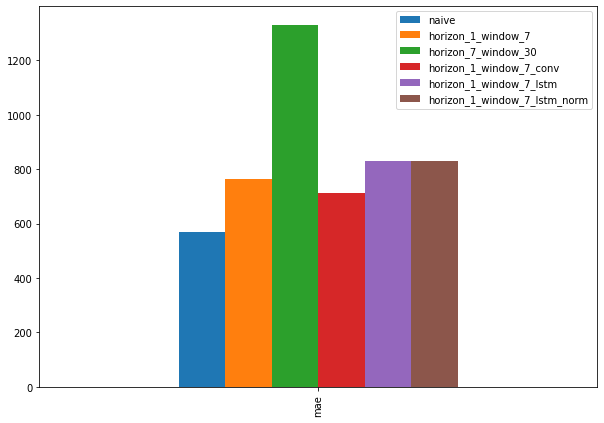

In [ ]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"],
              "horizon_1_window_7_conv": model_4_results["mae"],
              "horizon_1_window_7_lstm": model_5_results["mae"],
              "horizon_1_window_7_lstm_norm": model_6_results["mae"],
              }
             , index=["mae"]).plot(figsize=(10, 7), kind="bar");